---
# ARCHIVE !!!

Some old code, it needs a review.

---

In [1]:
"""
This script reads all the behav files and creates a summary, including all the info about the sessions.
It also checks if the behav file is corrupt or if spike sorting has been done for each session.
"""
#%%
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd
import numpy as np

from behav_analysis_tools import *
from popy.io_tools import *

# Load all sessions and concatenate them into one df

In [2]:
np.arange(10)[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [3]:
def add_inverse_trial_in_block(behav_all):
    # group by monke, session, block
    for info, subdf in behav_all.groupby(['monkey', 'session', 'block_id']):
        # write back to the original dataframe
        behav_all.loc[subdf.index, 'inverse_trial_id_in_block'] = np.arange(len(subdf))[::-1]

    # type is int
    behav_all['inverse_trial_id_in_block'] = behav_all['inverse_trial_id_in_block'].astype(int)

    return behav_all

In [4]:
# load all session data, remove those labeled as invalid
behav_all = get_concat_data()
behav_all = add_trial_in_block(behav_all)
behav_all = add_inverse_trial_in_block(behav_all)

# only reserve columns monkey, session, trial_id_in_block, feedback
behav_all = behav_all[['monkey', 'session', 'block_id', 'trial_id_in_block', 'inverse_trial_id_in_block', 'switch', 'feedback']]

behav_all.head(50)

NameError: name 'get_concat_data' is not defined

In [5]:
# loop through each session id, in each trial compare feedback (win/lose) to switch (stay/shift)
for info, subdf in behav_all.groupby(['monkey', 'session']):
    #behav_temp = behav_monkey[behav_monkey['session'] == session_id]

    # shift feedback to higher index
    subdf['feedback_shifted'] = subdf['feedback'].shift(+1)

    # compare feedback to switch
    subdf['win_lose_stay_shift'] = np.nan
    subdf.loc[(subdf['feedback_shifted'] == 1) & (subdf['switch'] == 0), 'win_lose_stay_shift'] = 'win_stay'
    subdf.loc[(subdf['feedback_shifted'] == 0) & (subdf['switch'] == 0), 'win_lose_stay_shift'] = 'lose_stay'
    subdf.loc[(subdf['feedback_shifted'] == 1) & (subdf['switch'] == 1), 'win_lose_stay_shift'] = 'win_shift'
    subdf.loc[(subdf['feedback_shifted'] == 0) & (subdf['switch'] == 1), 'win_lose_stay_shift'] = 'lose_shift'

    # save to behav_all
    behav_all.loc[subdf.index, 'win_lose_stay_shift'] = subdf['win_lose_stay_shift']

behav_all = behav_all.dropna()

behav_all.head(50)

,monkey,session,block_id,trial_id_in_block,inverse_trial_id_in_block,switch,feedback,win_lose_stay_shift
1,ka,010720,0,1,41,False,False,win_stay
2,ka,010720,0,2,40,True,True,lose_shift
3,ka,010720,0,3,39,False,False,win_stay
4,ka,010720,0,4,38,True,True,lose_shift
5,ka,010720,0,5,37,False,False,win_stay
6,ka,010720,0,6,36,True,True,lose_shift
7,ka,010720,0,7,35,False,True,win_stay
8,ka,010720,0,8,34,False,True,win_stay
9,ka,010720,0,9,33,False,True,win_stay
10,ka,010720,0,10,32,False,True,win_stay


# Statistics

## 1. Overall (all sessions together)

In [6]:
# build a summary table
summary = pd.DataFrame(columns=['monkey', 'session', 'win_lose_stay_shift', 'counts'])
for info, subdf in behav_all.groupby(['monkey', 'session']):
    dict_temp = {'monkey': [], 'session': [], 'win_lose_stay_shift': [], 'counts': []}
    for win_lose_stay_shift in ['win_stay', 'win_shift', 'lose_stay', 'lose_shift']:
        dict_temp['monkey'].append(info[0])
        dict_temp['session'].append(info[1])
        dict_temp['win_lose_stay_shift'].append(win_lose_stay_shift)
        dict_temp['counts'].append(len(subdf[subdf['win_lose_stay_shift'] == win_lose_stay_shift]))
    df_dict_temp = pd.DataFrame.from_dict(dict_temp)
    summary = pd.concat([summary, df_dict_temp])

summary = summary.pivot(index=['monkey', 'session'], columns='win_lose_stay_shift', values='counts')  # reshape: each category in a column
summary['total'] = summary.sum(axis=1)
summary['win_shift_ratio'] = summary['win_shift'] / summary['total']
summary['win_stay_ratio'] = summary['win_stay'] / summary['total']
summary['lose_shift_ratio'] = summary['lose_shift'] / summary['total']
summary['lose_stay_ratio'] = summary['lose_stay'] / summary['total']

summary['p(stay|win)'] = summary['win_stay'] / (summary['win_stay'] + summary['win_shift'])
summary['p(shift|win)'] = summary['win_shift'] / (summary['win_stay'] + summary['win_shift'])
summary['p(stay|lose)'] = summary['lose_stay'] / (summary['lose_stay'] + summary['lose_shift'])
summary['p(shift|lose)'] = summary['lose_shift'] / (summary['lose_stay'] + summary['lose_shift'])

summary = summary.reset_index()
summary.head()

win_lose_stay_shift,monkey,session,lose_shift,lose_stay,win_shift,win_stay,total,win_shift_ratio,win_stay_ratio,lose_shift_ratio,lose_stay_ratio,p(stay|win),p(shift|win),p(stay|lose),p(shift|lose)
0,ka,010720,61,162,1,243,467,0.002141,0.520343,0.130621,0.346895,0.995902,0.004098,0.726457,0.273543
1,ka,010922,16,70,1,123,210,0.004762,0.585714,0.07619,0.333333,0.991935,0.008065,0.813953,0.186047
2,ka,011020,13,66,0,126,205,0.0,0.614634,0.063415,0.321951,1.0,0.0,0.835443,0.164557
3,ka,020622,45,104,0,191,340,0.0,0.561765,0.132353,0.305882,1.0,0.0,0.697987,0.302013
4,ka,030322,29,147,1,244,421,0.002375,0.579572,0.068884,0.349169,0.995918,0.004082,0.835227,0.164773


In [7]:
# table of win/lose vs stay/shift, per monkey
summary.groupby(['monkey']).mean()

table_skeleton = pd.DataFrame(columns=['win', 'lose'], index=['stay', 'shift'])

for monkey, df_monkey in summary.groupby(['monkey']):
    table_monkey = table_skeleton.copy()

    table_monkey.loc['stay', 'win'] = df_monkey['win_stay_ratio'].mean().round(2)
    table_monkey.loc['stay', 'lose'] = df_monkey['lose_stay_ratio'].mean().round(2)
    table_monkey.loc['shift', 'win'] = df_monkey['win_shift_ratio'].mean().round(2)
    table_monkey.loc['shift', 'lose'] = df_monkey['lose_shift_ratio'].mean().round(2)

    print(monkey)
    print(table_monkey)
    print(f'p(stay|win) = {df_monkey["p(stay|win)"].mean().round(2)}')
    print(f'p(shift|lose) = {df_monkey["p(shift|lose)"].mean().round(2)}')


('ka',)
        win  lose
stay   0.57  0.33
shift   0.0   0.1
p(stay|win) = 1.0
p(shift|lose) = 0.22
('po',)
        win  lose
stay   0.49  0.29
shift  0.03   0.2
p(stay|win) = 0.94
p(shift|lose) = 0.4


## 2. time resolved - per session

In [8]:
# convert from ddmmyy to numpy date
def to_date(date_str):
    return np.datetime64('20' + date_str[4:] + '-' + date_str[2:4] + '-' + date_str[:2])

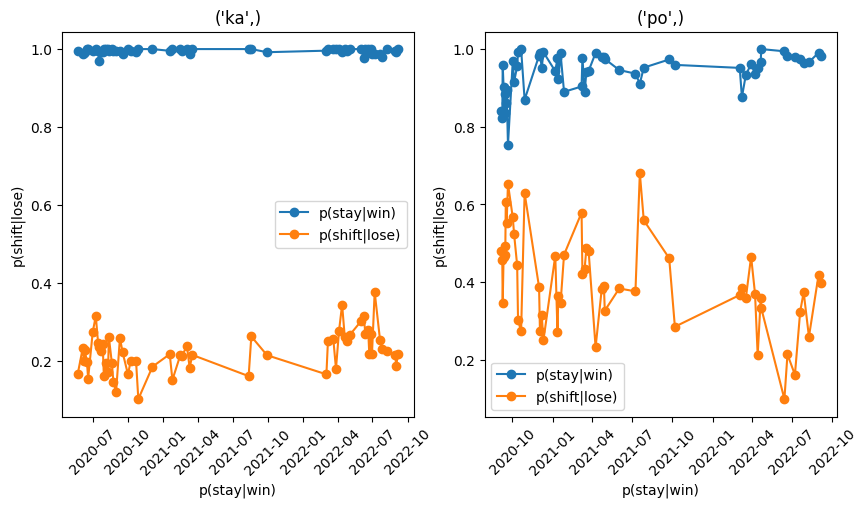

In [9]:
# plot p(stay|win) vs p(shift|lose) for each monkey, per session

# add time field
summary['date'] = summary['session'].apply(to_date)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, (monkey, df_monkey) in enumerate(summary.groupby(['monkey'])):
    # sort by date
    df_monkey = df_monkey.sort_values(by=['date'])

    axs[i].plot(df_monkey['date'], df_monkey['p(stay|win)'], '-o', label='p(stay|win)')
    axs[i].plot(df_monkey['date'], df_monkey['p(shift|lose)'], '-o', label='p(shift|lose)')

    axs[i].set_xlabel('p(stay|win)')
    axs[i].set_ylabel('p(shift|lose)')
    axs[i].set_title(monkey)
    axs[i].legend()
    # rotate x axis labels
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)


plt.show()

## 3. time resolved - per block

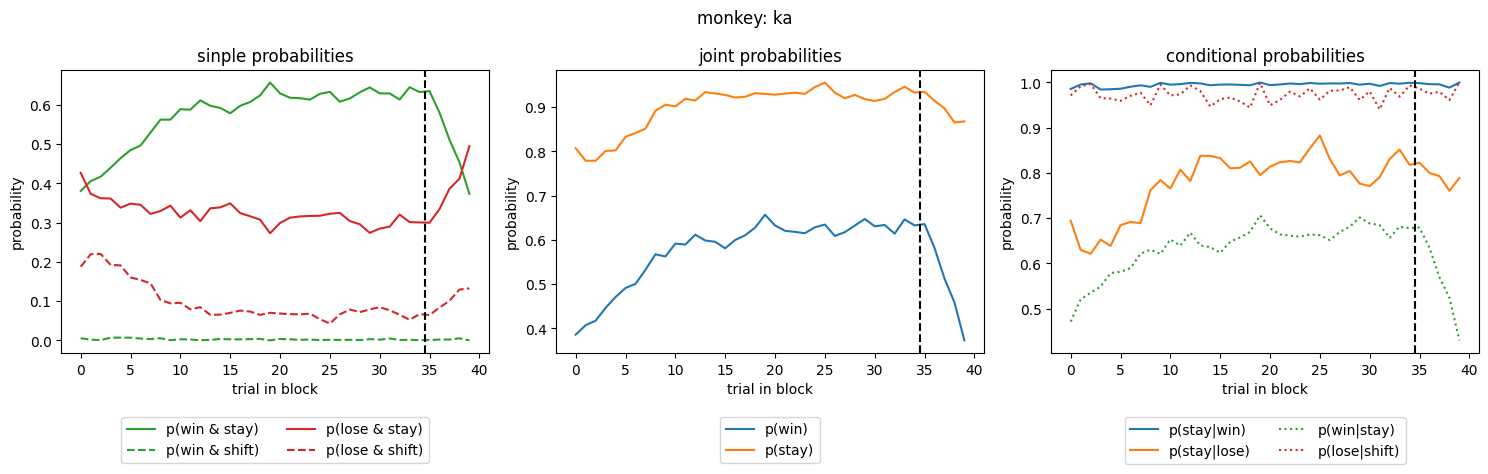

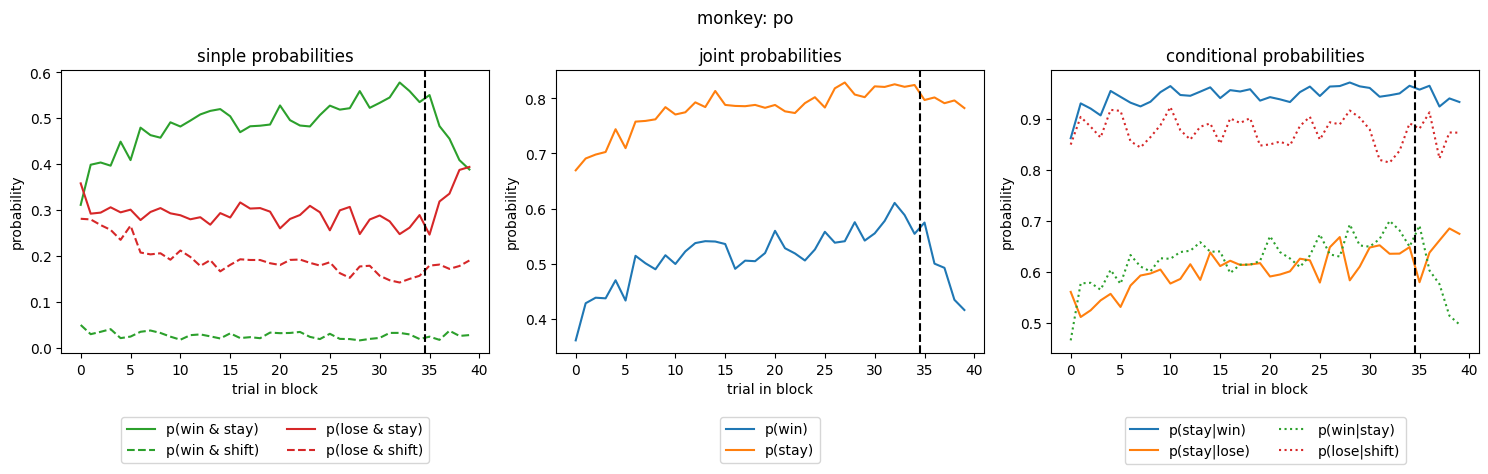

In [95]:
for monkey in (['ka', 'po']):
    behav_temp = behav_all[(behav_all['monkey'] == monkey)]

    shifts_both = []
    stay_both = []

    shifts_win = []
    shifts_lose = []
    stay_win = []
    stay_lose = []

    for info, df_session in behav_temp.groupby(['session', 'block_id']):
        switch_vector = df_session['win_lose_stay_shift'].values
        # get data
        switch_vector_win_shift = switch_vector == 'win_shift'
        switch_vector_lose_shift = switch_vector == 'lose_shift'
        switch_vector_both_shift = switch_vector_win_shift | switch_vector_lose_shift

        switch_vector_win_stay = switch_vector == 'win_stay'
        switch_vector_lose_stay = switch_vector == 'lose_stay'
        switch_vector_both_stay = np.logical_or(switch_vector == 'win_stay', switch_vector == 'lose_stay')

        # to int
        switch_vector_both_shift = switch_vector_both_shift.astype(int)
        switch_vector_win_shift = switch_vector_win_shift.astype(int)
        switch_vector_lose_shift = switch_vector_lose_shift.astype(int)
        switch_vector_both_stay = switch_vector_both_stay.astype(int)
        switch_vector_win_stay = switch_vector_win_stay.astype(int)
        switch_vector_lose_stay = switch_vector_lose_stay.astype(int)

        # interpolate to len 40
        switch_vector_both_shift = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_both_shift)), switch_vector_both_shift)
        switch_vector_win_shift = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_win_shift)), switch_vector_win_shift)
        switch_vector_lose_shift = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_lose_shift)), switch_vector_lose_shift)
        switch_vector_both_stay = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_both_stay)), switch_vector_both_stay)
        switch_vector_win_stay = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_win_stay)), switch_vector_win_stay)
        switch_vector_lose_stay = np.interp(np.linspace(0, 40, 40), np.linspace(0, 40, len(switch_vector_lose_stay)), switch_vector_lose_stay)
        
        shifts_both.append(switch_vector_both_shift)
        shifts_win.append(switch_vector_win_shift)
        shifts_lose.append(switch_vector_lose_shift)
        stay_both.append(switch_vector_both_stay)
        stay_win.append(switch_vector_win_stay)
        stay_lose.append(switch_vector_lose_stay)


    shifts_both = np.array(shifts_both)
    shifts_win = np.array(shifts_win)
    shifts_lose = np.array(shifts_lose)
    stay_both = np.array(stay_both)
    stay_win = np.array(stay_win)
    stay_lose = np.array(stay_lose)


    plt.figure(figsize=(15, 5))
    plt.suptitle('monkey: '+monkey)

    plt.subplot(131)
    plt.title('sinple probabilities')
    plt.plot(np.mean(stay_win, axis=0), label='p(win & stay)', color='tab:green', linestyle='-')
    plt.plot(np.mean(shifts_win, axis=0), label='p(win & shift)', color='tab:green', linestyle='--')
    plt.plot(np.mean(stay_lose, axis=0), label='p(lose & stay)', color='tab:red', linestyle='-')
    plt.plot(np.mean(shifts_lose, axis=0), label='p(lose & shift)', color='tab:red', linestyle='--')
    plt.axvline(x=34.5, color='black', linestyle='--')

    plt.xlabel('trial in block')
    plt.ylabel('probability')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    plt.subplot(132)

    plt.title('joint probabilities')
    #plt.plot(np.mean(shifts_lose, axis=0) + np.mean(stay_lose, axis=0), label='p(lose)', color='tab:red', linestyle='-')
    plt.plot(np.mean(shifts_win, axis=0) + np.mean(stay_win, axis=0), label='p(win)', linestyle='-')
    #plt.plot(np.mean(shifts_win, axis=0) + np.mean(shifts_lose, axis=0), label='p(shift)', color='black', linestyle='--')
    plt.plot(np.mean(stay_win, axis=0) + np.mean(stay_lose, axis=0), label='p(stay)')

    plt.axvline(x=34.5, color='black', linestyle='--')
    plt.xlabel('trial in block')
    plt.ylabel('probability')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
    
    plt.subplot(133)
    plt.title('conditional probabilities')
    # p(stay|win)
    plt.plot(np.mean(stay_win, axis=0) / (np.mean(stay_win, axis=0) + np.mean(shifts_win, axis=0)), label='p(stay|win)', linestyle='-')
    # p(shift|lose)
    plt.plot(np.mean(stay_lose, axis=0) / (np.mean(stay_lose, axis=0) + np.mean(shifts_lose, axis=0)), label='p(stay|lose)', linestyle='-')
    # p(win|stay)
    plt.plot(np.mean(stay_win, axis=0) / (np.mean(stay_win, axis=0) + np.mean(stay_lose, axis=0)), label='p(win|stay)', linestyle='dotted')
    # p(lose|shift)
    plt.plot(np.mean(shifts_lose, axis=0) / (np.mean(shifts_win, axis=0) + np.mean(shifts_lose, axis=0)), label='p(lose|shift)', linestyle='dotted')
    plt.axvline(x=34.5, color='black', linestyle='--')

    plt.xlabel('trial in block')
    plt.ylabel('probability')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)


    plt.tight_layout()
    plt.show()

        


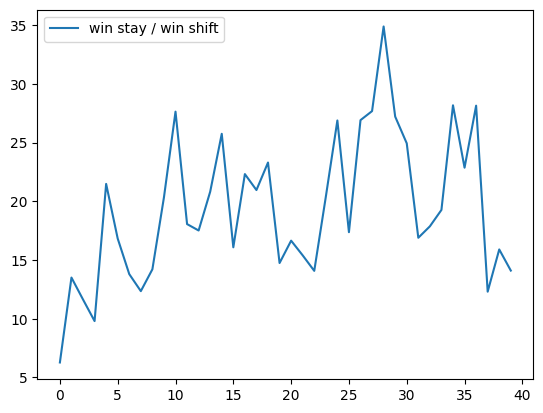

In [36]:
#plt.plot(lose_stay, label='lose stay')
#plt.plot(lose_shift, label='lose shift')
#plt.plot(stay_lose.mean(axis=0) / shifts_lose.mean(axis=0), label='lose stay / lose shift')
plt.plot(stay_win.mean(axis=0) / shifts_win.mean(axis=0), label='win stay / win shift')
plt.plot()
#plt.ylim([0, 1])
plt.legend()

#  delete this

In [11]:
# build a summary table

summaries = {'beginning': [], 'end': []}

for summary_type in summaries.keys():
    if summary_type == 'beginning':
        trial_ids_marker = 'trial_id_in_block'
    elif summary_type == 'end':
        trial_ids_marker = 'inverse_trial_id_in_block'
    
    behav_temp = behav_all[behav_all[trial_ids_marker] <= 20]

    summary = pd.DataFrame(columns=['monkey', 'trial_ids', 'win_lose_stay_shift', 'counts'])
    for info, subdf in behav_temp.groupby(['monkey', trial_ids_marker]):
        dict_temp = {'monkey': [], 'trial_ids': [], 'win_lose_stay_shift': [], 'counts': []}
        for win_lose_stay_shift in ['win_stay', 'win_shift', 'lose_stay', 'lose_shift']:
            dict_temp['monkey'].append(info[0])
            dict_temp['trial_ids'].append(info[1])
            dict_temp['win_lose_stay_shift'].append(win_lose_stay_shift)
            dict_temp['counts'].append(len(subdf[subdf['win_lose_stay_shift'] == win_lose_stay_shift]))
        df_dict_temp = pd.DataFrame.from_dict(dict_temp)
        summary = pd.concat([summary, df_dict_temp])

    summary = summary.pivot(index=['monkey', 'trial_ids'], columns='win_lose_stay_shift', values='counts')  # reshape: each category in a column
    summary['total'] = summary.sum(axis=1)
    summary['win_shift_ratio'] = summary['win_shift'] / summary['total']
    summary['win_stay_ratio'] = summary['win_stay'] / summary['total']
    summary['lose_shift_ratio'] = summary['lose_shift'] / summary['total']
    summary['lose_stay_ratio'] = summary['lose_stay'] / summary['total']
    summary = summary.reset_index()

    # drop trial_id_in_block > 20
    summary = summary[summary['trial_ids'] <= 20]

    summary['p(stay|win)'] = summary['win_stay'] / (summary['win_stay'] + summary['win_shift'])
    summary['p(shift|win)'] = summary['win_shift'] / (summary['win_stay'] + summary['win_shift'])
    summary['p(stay|lose)'] = summary['lose_stay'] / (summary['lose_stay'] + summary['lose_shift'])
    summary['p(shift|lose)'] = summary['lose_shift'] / (summary['lose_stay'] + summary['lose_shift'])

    summaries[summary_type] = summary

summaries['beginning'].head(42)

win_lose_stay_shift,monkey,trial_ids,lose_shift,lose_stay,win_shift,win_stay,total,win_shift_ratio,win_stay_ratio,lose_shift_ratio,lose_stay_ratio,p(stay|win),p(shift|win),p(stay|lose),p(shift|lose)
0,ka,0,82,219,1,183,485,0.002062,0.37732,0.169072,0.451546,0.994565,0.005435,0.727575,0.272425
1,ka,1,116,207,2,219,544,0.003676,0.402574,0.213235,0.380515,0.99095,0.00905,0.640867,0.359133
2,ka,2,122,198,0,223,543,0.0,0.410681,0.224678,0.364641,1.0,0.0,0.61875,0.38125
3,ka,3,109,196,3,235,543,0.005525,0.432781,0.200737,0.360958,0.987395,0.012605,0.642623,0.357377
4,ka,4,112,175,5,252,544,0.009191,0.463235,0.205882,0.321691,0.980545,0.019455,0.609756,0.390244
5,ka,5,92,191,3,258,544,0.005515,0.474265,0.169118,0.351103,0.988506,0.011494,0.674912,0.325088
6,ka,6,85,182,3,273,543,0.005525,0.502762,0.156538,0.335175,0.98913,0.01087,0.681648,0.318352
7,ka,7,80,192,3,267,542,0.005535,0.49262,0.147601,0.354244,0.988889,0.011111,0.705882,0.294118
8,ka,8,65,177,2,299,543,0.003683,0.550645,0.119705,0.325967,0.993355,0.006645,0.731405,0.268595
9,ka,9,57,181,2,304,544,0.003676,0.558824,0.104779,0.332721,0.993464,0.006536,0.760504,0.239496


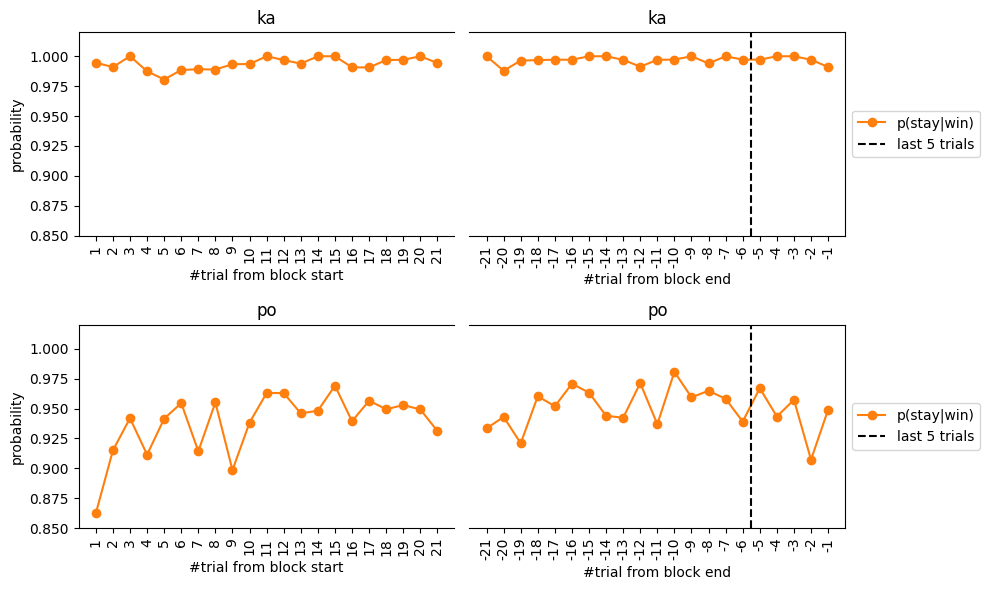

In [12]:
# plot p(stay|win) vs p(shift|lose) for each monkey, per trial_id_in_block
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for j, (name, summary) in enumerate(summaries.items()):
    for i, (monkey, df_monkey) in enumerate(summary.groupby(['monkey'])):
        # sort by date
        df_monkey = df_monkey.sort_values(by=['trial_ids'])

        axs[i, j].plot(df_monkey['trial_ids'], df_monkey['p(stay|win)'], '-o', label='p(stay|win)', color='tab:orange')
        #axs[i, j].plot(df_monkey['trial_ids'], df_monkey['p(shift|lose)'], '-o', label='p(shift|lose)', color='tab:blue')

        axs[i, j].set_title(monkey[0])
        axs[i, j].set_ylim([0.85, 1.02])

        if name == 'beginning':
            # set x tick names from 1 to 20
            tick_names = np.arange(1, 22).astype(str)
            axs[i, j].set_xticks(np.arange(0, 21))
            axs[i, j].set_xticklabels(tick_names)
            axs[i, j].set_xlabel('#trial from block start')
            axs[i, j].set_ylabel('probability')
            #remove right spine and yticks
            axs[i, j].spines['right'].set_visible(False)

        elif name == 'end':
            tick_names = np.arange(-21, 0).astype(str)
            axs[i, j].set_xticks(np.arange(0, 21))
            axs[i, j].set_xticklabels(tick_names)
            axs[i, j].set_xlabel('#trial from block end')
            # remove left spine and top
            axs[i, j].spines['left'].set_visible(False)

            axs[i, j].set_yticks([])
            # dashed line at x=15
            axs[i, j].axvline(x=15.5, linestyle='--', color='k', label='last 5 trials')
            # legend loc outside the plot (rights side)
            axs[i, j].legend(loc='center left', bbox_to_anchor=(1, 0.5))


        # rote x axis labels
        for tick in axs[i, j].get_xticklabels():
            tick.set_rotation(90)


plt.tight_layout()